<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dependenices" data-toc-modified-id="Dependenices-1">Dependenices</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2">Functions</a></span></li><li><span><a href="#Paths" data-toc-modified-id="Paths-3">Paths</a></span></li><li><span><a href="#Main" data-toc-modified-id="Main-4">Main</a></span></li><li><span><a href="#Run-qusage" data-toc-modified-id="Run-qusage-5">Run qusage</a></span></li><li><span><a href="#Load-pathways" data-toc-modified-id="Load-pathways-6">Load pathways</a></span></li><li><span><a href="#Validate-with-proteomics" data-toc-modified-id="Validate-with-proteomics-7">Validate with proteomics</a></span></li></ul></div>

# Dependenices

In [2]:
options(scipen = 999)

In [3]:
library(gridExtra)
library(grid)
library(qusage)

Loading required package: limma



# Functions

In [51]:
source("~/OneDrive - UHN/R_src/ggplot2_theme.R")
source("~/OneDrive - UHN/R_src/color_schemes.R")
source("~/OneDrive - UHN/R_src/plotting_functions.R")
source("~/OneDrive - UHN/R_src/Heatmap_functions.R")

In [95]:
hallmark_IC_stats_ridge <- function(proteinmat, metadata, hallmark){
    
    protein_mat_pathway <- as.matrix(proteinmat[rownames(proteinmat) %in% Hs.H[[hallmark]], rownames(metadata)])
    print(dim(protein_mat_pathway))
    pathway_mean <- colMeans(protein_mat_pathway)
    
    metadata$pathway_mean <- pathway_mean
    
    print(pairwise.t.test(metadata$pathway_mean, metadata$immune_cluster, p.adjust = "bonferroni"))

    ridge_plot <- plot_ridge.fx(metadata, "pathway_mean")
    return(ridge_plot + labs(title = hallmark))
}

# Paths

In [6]:
datapath <- "/Users/anabbi/OneDrive - UHN/Documents/IPD2/Data/"
plotpath <- "/Users/anabbi/OneDrive - UHN/Documents/IPD2/Plots/"

# Main

In [7]:
Hs.H <- read.gmt(paste0(datapath, "DEG/h.all.v7.1.symbols.gmt"))  

In [8]:
load(file.path(datapath,"TME_clusters/IPD_estimate_metadata_IC.RData"))

In [9]:
load(paste0(datapath,"exp_mat/tpm_matrix_ped_final.RData"))

In [10]:
table(metadata_IC$immune_cluster)


Pediatric inflamed     Myeloid-driven     Pediatric cold    Immune excluded 
                90                279                393                163 

In [11]:
tpm_matrix_ped_final <- tpm_matrix_ped_final[,rownames(metadata_IC)]

In [12]:
tpm_matrix_ped_final[1:10,1:10]

,TARGET-30-PAIFXV-01A,TARGET-30-PAIPGU-01A,TARGET-30-PAISNS-01A,TARGET-30-PAITCI-01A,TARGET-30-PAIVHE-01A,TARGET-30-PAIXIF-01A,TARGET-30-PAKYZS-01A,TARGET-30-PAKZRH-01A,TARGET-30-PALBFW-01A,TARGET-30-PALCBW-01A
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TSPAN6,11.57,9.14,31.55,14.52,66.42,19.37,12.51,18.51,16.63,21.17
TNMD,0.10,0.08,0.00,0.00,0.00,0.00,0.00,0.17,0.17,0.19
DPM1,22.48,31.96,44.65,87.72,36.07,23.47,27.27,43.03,32.10,24.11
SCYL3,2.37,1.78,3.77,2.49,4.91,3.00,3.22,3.84,5.51,5.68
C1orf112,1.46,3.12,8.13,3.70,6.83,5.12,2.21,3.95,3.18,2.43
FGR,2.05,4.70,2.94,0.84,6.55,2.64,2.08,1.50,3.72,6.42
CFH,9.79,8.69,20.68,23.68,36.96,57.95,26.22,10.43,31.97,103.99
FUCA2,14.27,11.80,9.61,13.57,18.67,22.23,23.67,22.98,16.85,42.18
GCLC,5.77,4.42,4.23,6.69,13.15,2.52,9.76,6.68,14.60,10.05


In [13]:
# log2 for qusage
tpm_matrix_ped_final_log <- log2(tpm_matrix_ped_final + 1)

# Run qusage

In [ ]:
list_pathwaytables <- parallel::mclapply(unique(metadata_IC$immune_cluster), function(x){
    
    mycluster <- x

    message(mycluster)
    
    tmp <- metadata_IC
    tmp$class <- NA
    tmp$class[ tmp$immune_cluster == mycluster] <- mycluster
    tmp$class[ tmp$immune_cluster != mycluster] <- "Others" 

    tmp$class <- factor(tmp$class)
    
    mycontrast <- paste0(mycluster, "-Others")
    
    myresults <- qgen(tpm_matrix_ped_final_log,
                  design = tmp[,c("sample_id", "cohort", "class", "group")],
                  geneSets = Hs.H,
                  fixed= ~ group + cohort + class, #control for batch and cohort
                  contrast.factor = ~ class,
                  contrast= mycontrast,
                  design.sampleid= "sample_id")
    
    mytable <- qsTable(myresults, number = 50)
    mytable$contrast <- mycontrast    
    
    return(mytable)
    
}, mc.cores = 3)

In [ ]:
pathwaytable <- do.call("rbind", list_pathwaytables)

In [ ]:
head(pathwaytable)

In [ ]:
save(pathwaytable, file = paste0(datapath, "DEG/pathwaytable.RData"))

# Load pathways

In [14]:
load(file = paste0(datapath, "DEG/pathwaytable.RData"))

In [15]:
head(pathwaytable)

,pathway.name,log.fold.change,p.Value,FDR,contrast
,<chr>,<dbl>,<dbl>,<dbl>,<chr>
31,HALLMARK_INFLAMMATORY_RESPONSE,0.2256761,0,0,C2-Others
46,HALLMARK_ALLOGRAFT_REJECTION,0.2392878,0,0,C2-Others
7,HALLMARK_IL6_JAK_STAT3_SIGNALING,0.2702564,0,0,C2-Others
1,HALLMARK_TNFA_SIGNALING_VIA_NFKB,0.2755332,0,0,C2-Others
19,HALLMARK_INTERFERON_GAMMA_RESPONSE,0.2963696,0,0,C2-Others
18,HALLMARK_INTERFERON_ALPHA_RESPONSE,0.3175695,0,0,C2-Others


In [16]:
xlsx::write.xlsx(pathwaytable, file = "~/OneDrive - UHN/Documents/Manuscripts/IPD/v9/TableS7.xlsx",
                row.names = F)

In [17]:
summary(pathwaytable$log.fold.change)

      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-0.4991034 -0.0595144 -0.0008032  0.0222983  0.1043042  0.6466560 

In [18]:
summary(pathwaytable$FDR)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000000 0.0003008 0.0760154 0.2104938 0.3393969 0.9955480 

In [19]:
fc_tab <- pathwaytable[,c("pathway.name", "contrast","log.fold.change")]

fdr_tab <- pathwaytable[,c("pathway.name", "contrast","FDR")]

In [20]:
fc_mat <- tidyr::spread(fc_tab, key = contrast, value = log.fold.change)

fdr_mat <- tidyr::spread(fdr_tab, key = contrast, value = FDR)

In [21]:
rownames(fc_mat) <- fc_mat$pathway.name
fc_mat$pathway.name <- NULL
fc_mat <- as.matrix(fc_mat)

In [22]:
rownames(fdr_mat) <- fdr_mat$pathway.name
fdr_mat$pathway.name <- NULL
fdr_mat <- as.matrix(fdr_mat)

In [23]:
head(fdr_mat)

,C1-Others,C2-Others,C3-Others,C4-Others
HALLMARK_ADIPOGENESIS,0.0170638677549,0.46929424820587,0.133335830321,0.417995887
HALLMARK_ALLOGRAFT_REJECTION,0.0000000000000,0.00000000000000,0.000000720659,0.000000000
HALLMARK_ANDROGEN_RESPONSE,0.0749467607812,0.03899330592721,0.049373804710,0.215965851
HALLMARK_ANGIOGENESIS,0.0000002169008,0.00000002051886,0.004533356001,0.000000000
HALLMARK_APICAL_JUNCTION,0.0221075329021,0.11995234008688,0.124608219426,0.098497288
HALLMARK_APICAL_SURFACE,0.0001492474463,0.04267685421600,0.050067435291,0.006105257


In [24]:
dim(fc_mat)

[1] 50  4

Remove those pathways with fdr > 0.1 in all clusters

In [25]:
fc_mat_pathways <- fc_mat[rownames(fdr_mat)[rowSums(fdr_mat > 0.1) <= 2],]

fdr_mat_pathways <- fdr_mat[rownames(fdr_mat)[rowSums(fdr_mat > 0.1) <= 2],]

In [26]:
dim(fc_mat_pathways)

[1] 29  4

In [27]:
head(fc_mat_pathways)

,C1-Others,C2-Others,C3-Others,C4-Others
HALLMARK_ALLOGRAFT_REJECTION,0.6227865,0.23928784,-0.16645024,-0.43922019
HALLMARK_ANDROGEN_RESPONSE,0.1047807,0.08529859,-0.07434887,-0.05947901
HALLMARK_ANGIOGENESIS,0.3413720,0.24674186,-0.12708994,-0.34185104
HALLMARK_APICAL_JUNCTION,0.1170657,0.05774794,-0.05087814,-0.06774862
HALLMARK_APICAL_SURFACE,0.1588116,0.06282899,-0.05471159,-0.09412805
HALLMARK_APOPTOSIS,0.3312808,0.17732190,-0.11822580,-0.25385839


In [28]:
#clean up row and colnames
rownames(fc_mat_pathways) <- gsub("HALLMARK_", "", rownames(fc_mat_pathways))
rownames(fc_mat_pathways) <- gsub("_", " ", rownames(fc_mat_pathways))

colnames(fc_mat_pathways) <- gsub("-Others", "", colnames(fc_mat_pathways))

In [29]:
summary(as.vector(fc_mat_pathways))

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.499103 -0.103879  0.008798  0.030468  0.158927  0.646656 

In [30]:
col_fun= colorRamp2(c(-0.6, 0, 0.6), c("blue", "white", "red"))
    
pathways_hm = Heatmap(fc_mat_pathways,
                       #titles and names   
                       name = "Log2_FC",   
                       show_row_names = TRUE,
                       show_column_names = TRUE,     
                       #clusters and orders  
                       cluster_columns = TRUE,
                       cluster_rows = TRUE,
                       show_column_dend = TRUE,
                       #aesthestics
                       col = col_fun,
                       column_names_gp = gpar(fontsize = 10),
                       row_names_gp = gpar(fontsize = 10),
                       height = unit(29, "cm"), width = unit(4, "cm"),
                       column_title_gp = gpar(fontsize = 10),
                       column_title = NULL,
                       row_title = NULL,

           
                    column_names_rot = 45,
                      show_heatmap_legend = FALSE
                      
                     )

            cell_fun = function(j, i, x, y, width, height, fill){
                          if(fdr_mat_pathways[i, j] > 0.10)
                              grid.points(x, y, pch = 7,size = unit(13,"mm")
                                        )},

[1] "ROOT"                      "global"                   
 [3] "global_layout"             "global-heatmaplist"       
 [5] "main_heatmap_list"         "heatmap_Log2_FC"          
 [7] "Log2_FC_heatmap_body_wrap" "Log2_FC_heatmap_body_1_1" 
 [9] "Log2_FC_dend_row_1"        "Log2_FC_dend_column_1"    
[11] "Log2_FC_row_names_1"       "Log2_FC_column_names_1"

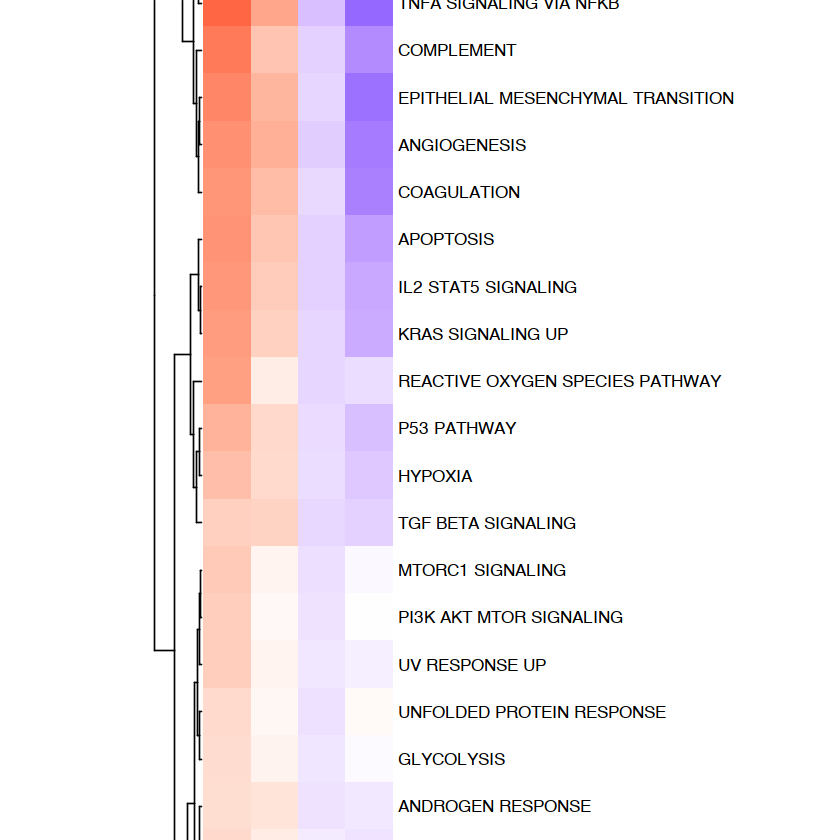

In [31]:
draw(pathways_hm)

list_components()

In [31]:
pdf(paste0(plotpath, "heatmap_pathways_MSigDB.pdf"),
   width = 10, height = 45)


draw(pathways_hm)

decorate_heatmap_body("Log2_FC", {
    grid.rect(x = 0, y = 1, just = c("left", "top"),
          width = 1,height = 0.345, gp = gpar(col = "black", lwd = 5))
})

dev.off()

pdf 
  2

In [41]:
col_fun= colorRamp2(c(-0.6, 0, 0.6), c("blue", "white", "red"))

qusage_lgd = Legend(col_fun = col_fun, title = "Fold change\n(Log2)",
                   at = c(-0.6, 0, 0.6), legend_height = unit(2, "cm"))

  pdf(file = paste0(plotpath,"qusage_legend.pdf"),
      width = 8, 
      height = 8,
      useDingbats = FALSE)
  draw(qusage_lgd)
  dev.off() 

pdf 
  2

# Validate with proteomics

Input gene list to cptact data viewer and download

In [32]:
proteom <- data.table::fread(file = paste0(datapath, "Proteomics/CPTAC3-pbt_HALLMARK_genes_4proteomics.csv"), sep = ",",
                             check.names = F, header = T, na.strings = c("", "NA"), 
                             stringsAsFactors = F)

In [33]:
proteom <- as.data.frame(proteom)

In [34]:
proteom <- proteom[ grepl("proteo",proteom$idx),]

In [35]:
rownames_proteom <- proteom$`Gene symbol`

rownames(proteom) <- proteom$`Gene symbol`
proteom$`Gene symbol` <- NULL
proteom$idx <- NULL
proteom$`Data type` <- NULL

In [36]:
proteom <- as.matrix(proteom)

In [37]:
proteom <- apply(proteom,2, as.numeric)

In [38]:
rownames(proteom) <- rownames_proteom

In [39]:
summary(unlist(proteom[1,]))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-2.0723 -0.7495 -0.1233  0.0000  0.6953  2.8014 

In [40]:
colnames(proteom) <- gsub("X", "", colnames(proteom))
colnames(proteom) <- gsub("[.]", "-", colnames(proteom))

In [41]:
head(proteom)

,7316-872,7316-2151,7316-2170,7316-2146,7316-3319,7316-130,7316-2648,7316-2144,7316-384,7316-443,⋯,7316-957,7316-156,7316-154,7316-932,7316-368,7316-146,7316-475,7316-488,7316-954,7316-2663
A2M,1.17027033,-0.5743360,0.59496849,-0.6335644,0.6997003,-0.83742105,-2.0722576,-0.006544646,1.2974038,0.6979533,⋯,1.6602089,-0.05780405,1.66167839,-1.6368700,0.9715630,0.885687257,-0.054627732,0.7410713,0.1919530,-1.094637979
ABCB1,-0.08381773,0.4717423,0.08782766,-0.5069743,-0.2725235,1.14993700,-0.4286241,0.297925775,-2.7538323,-0.9601827,⋯,-0.3829181,-0.56124478,0.14832536,0.5554954,-0.2554827,-0.003093275,-0.100305943,0.3498220,0.3497704,-0.008693533
ABCE1,-0.96223316,-1.5030361,-1.69113011,-0.1859401,-0.4820084,-3.34370824,-1.2929395,-0.177119458,-1.2893723,0.4852315,⋯,1.5011056,0.51069457,0.34370090,-0.8081195,1.6206934,0.984334910,1.037286490,0.3146364,-0.4907370,-0.071388368
ABI1,-0.72795362,0.9738262,-1.30277822,-0.8145938,-1.4309733,-0.92663925,-1.5725272,-0.746616212,-0.5254130,-0.2546989,⋯,1.3292764,0.13421933,0.02902334,0.9220527,0.8975631,1.694717193,1.503893315,1.3250068,1.3729214,1.336956716
ACACA,0.26814355,-0.2418990,0.07250943,-1.5814215,-1.8205667,0.06561383,-2.0507721,-0.407322123,-2.0954588,-1.1982217,⋯,-0.4373494,2.26186969,-1.42696810,2.1766821,-0.4053189,-0.017007153,-0.001847593,-0.4182093,-0.4174602,-1.013486751
ACHE,-0.89310870,0.4170447,-0.61106041,-0.9032629,-0.4612296,0.18356565,-1.0152332,-0.326212420,0.5634417,0.1389767,⋯,0.2255436,-0.06896869,0.24250405,-0.1847278,0.4008109,0.058523880,0.097098904,0.1881703,0.6694573,0.627180792


In [42]:
metadata_IC_proteom <- metadata_IC[metadata_IC$sample_id %in% colnames(proteom),]

In [43]:
dim(metadata_IC_proteom)

[1] 147  24

In [121]:
coag <- hallmark_IC_stats_ridge(proteom, metadata_IC_proteom, "HALLMARK_COAGULATION")

label.df <- data.frame(x = c(1,1), y = c(3.3, 4.3))

coag <- coag + geom_text(data = label.df,aes(x = x, y = y), label = c("*", "***"), size = 15) +
ggtitle(expression(~underline("Coagulation (n = 47)"))) + labs(x = "Average protein z score") +
theme(axis.text.y = element_blank(), plot.margin = unit(c(1,0,0,0), "cm"))

[1]  47 147

	Pairwise comparisons using t tests with pooled SD 

data:  metadata$pathway_mean and metadata$immune_cluster 

                Pediatric inflamed Myeloid-driven Pediatric cold
Myeloid-driven  0.902              -              -             
Pediatric cold  0.012              0.000000000068 -             
Immune excluded 0.000031481441     0.000000000019 0.031         

P value adjustment method: bonferroni 


In [122]:
emt <- hallmark_IC_stats_ridge(proteom, metadata_IC_proteom, "HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION")

label.df <- data.frame(x = c(1,1), y = c(3.3, 4.3))

emt <- emt + geom_text(data = label.df,aes(x = x, y = y), label = "***", size = 15) +
ggtitle(expression(~underline("EMT (n = 27)"))) + labs(x = "Average protein z score") +
theme(axis.text.y = element_blank(), plot.margin = unit(c(1,0,0,0), "cm"))

[1]  27 147

	Pairwise comparisons using t tests with pooled SD 

data:  metadata$pathway_mean and metadata$immune_cluster 

                Pediatric inflamed Myeloid-driven Pediatric cold
Myeloid-driven  1.0000             -              -             
Pediatric cold  0.00001569102      0.00000007442  -             
Immune excluded 0.00000000572      0.00000000012  0.0055        

P value adjustment method: bonferroni 


In [123]:
angio <- hallmark_IC_stats_ridge(proteom, metadata_IC_proteom, "HALLMARK_ANGIOGENESIS")

label.df <- data.frame(x = c(1,1), y = c(3.3, 4.3))

angio <- angio + geom_text(data = label.df,aes(x = x, y = y), label = "***", size = 15) +
ggtitle(expression(~underline("Angiogenesis (n = 7)"))) + labs(x = "Average protein z score") +
theme(axis.text.y = element_blank(), plot.margin = unit(c(1,0,0,0), "cm"))

[1]   7 147

	Pairwise comparisons using t tests with pooled SD 

data:  metadata$pathway_mean and metadata$immune_cluster 

                Pediatric inflamed Myeloid-driven Pediatric cold
Myeloid-driven  1.00000            -              -             
Pediatric cold  0.00069            0.0000077      -             
Immune excluded 0.0000193          0.0000015      0.20270       

P value adjustment method: bonferroni 


In [124]:
ifng <- hallmark_IC_stats_ridge(proteom, metadata_IC_proteom, "HALLMARK_INTERFERON_GAMMA_RESPONSE")

label.df <- data.frame(x = c(1,1), y = c(3.3, 4.3))

ifng <- ifng + geom_text(data = label.df,aes(x = x, y = y), label = "***", size = 15) +
ggtitle(expression(~underline("IFN-gamma (n = 100)"))) + labs(x = "Average protein z score") +
theme(axis.text.y = element_blank())

[1] 100 147

	Pairwise comparisons using t tests with pooled SD 

data:  metadata$pathway_mean and metadata$immune_cluster 

                Pediatric inflamed  Myeloid-driven      Pediatric cold
Myeloid-driven  0.62582             -                   -             
Pediatric cold  0.00000000225047096 0.00000000000122628 -             
Immune excluded 0.00000000000003834 0.00000000000000038 0.00021       

P value adjustment method: bonferroni 


In [125]:
ifna <- hallmark_IC_stats_ridge(proteom,metadata_IC_proteom, "HALLMARK_INTERFERON_ALPHA_RESPONSE")

label.df <- data.frame(x = c(1,1),y = c(3.3, 4.3))

ifna <- ifna + geom_text(data = label.df,aes(x = x, y = y), label = "***", size = 15) +
ggtitle(expression(~underline("IFN-alpha (n = 56)"))) +labs(x = "Average protein z score") +
theme(axis.text.y = element_blank())

[1]  56 147

	Pairwise comparisons using t tests with pooled SD 

data:  metadata$pathway_mean and metadata$immune_cluster 

                Pediatric inflamed Myeloid-driven    Pediatric cold
Myeloid-driven  1.0000             -                 -             
Pediatric cold  0.000000053170279  0.000000000013452 -             
Immune excluded 0.000000000004458  0.000000000000024 0.0011        

P value adjustment method: bonferroni 


In [126]:
inflam <- hallmark_IC_stats_ridge(proteom,metadata_IC_proteom, "HALLMARK_INFLAMMATORY_RESPONSE")

label.df <- data.frame(x = c(1,1),y = c(3.3,4.3))

inflam <- inflam + geom_text(data = label.df,aes(x = x, y = y), label = "***", size = 15) +
ggtitle(expression(~underline("Inflammatory (n = 54)"))) + labs(x = "Average protein z score") +
theme(axis.text.y = element_blank())

[1]  54 147

	Pairwise comparisons using t tests with pooled SD 

data:  metadata$pathway_mean and metadata$immune_cluster 

                Pediatric inflamed Myeloid-driven    Pediatric cold
Myeloid-driven  1.0000             -                 -             
Pediatric cold  0.000048969297330  0.000000000002942 -             
Immune excluded 0.000000014165357  0.000000000000086 0.0046        

P value adjustment method: bonferroni 


In [127]:
il6 <- hallmark_IC_stats_ridge(proteom,metadata_IC_proteom, "HALLMARK_IL6_JAK_STAT3_SIGNALING")

label.df <- data.frame(x = c(1,1),y = c(3.3, 4.3))

il6 <- il6 + geom_text(data = label.df,aes(x = x, y = y), label = "***", size = 15) +
ggtitle(expression(~underline("IL6/JAK/STAT3 signaling (n = 23)"))) + labs(x = "Average protein z score") +
theme(axis.text.y = element_blank())

[1]  23 147

	Pairwise comparisons using t tests with pooled SD 

data:  metadata$pathway_mean and metadata$immune_cluster 

                Pediatric inflamed Myeloid-driven  Pediatric cold
Myeloid-driven  1.00000            -               -             
Pediatric cold  0.00020            0.0000000032803 -             
Immune excluded 0.0000000068966    0.0000000000005 0.00066       

P value adjustment method: bonferroni 


In [128]:
complement <- hallmark_IC_stats_ridge(proteom,metadata_IC_proteom, "HALLMARK_COMPLEMENT")

label.df <- data.frame(x = c(1,1),y = c(3.3, 4.3))

complement <- complement + geom_text(data = label.df,aes(x = x, y = y), label = "***", size = 15) +
ggtitle(expression(~underline("Complement (n = 123)"))) + labs(x = "Average protein z score") +
theme(axis.text.y = element_blank(), plot.margin = unit(c(1,0,0,0), "cm"))

[1] 123 147

	Pairwise comparisons using t tests with pooled SD 

data:  metadata$pathway_mean and metadata$immune_cluster 

                Pediatric inflamed Myeloid-driven    Pediatric cold
Myeloid-driven  1.0000             -                 -             
Pediatric cold  0.000027204190288  0.000000000002875 -             
Immune excluded 0.000000005782373  0.000000000000053 0.0035        

P value adjustment method: bonferroni 


In [132]:
tnfa <- hallmark_IC_stats_ridge(proteom,metadata_IC_proteom, "HALLMARK_TNFA_SIGNALING_VIA_NFKB")

label.df <- data.frame(x = c(1,1),y = c(3.3, 4.3))

tnfa <- tnfa + geom_text(data = label.df,aes(x = x, y = y), label = "***", size = 15) +
ggtitle(expression(~underline("TNFa signaling via NFkB (n = 51)"))) + labs(x = "Average protein z score") +
theme(axis.text.y = element_blank(),plot.margin = unit(c(1,0,0,0), "cm"))

[1]  51 147

	Pairwise comparisons using t tests with pooled SD 

data:  metadata$pathway_mean and metadata$immune_cluster 

                Pediatric inflamed Myeloid-driven Pediatric cold
Myeloid-driven  1.0000             -              -             
Pediatric cold  0.0002             0.000000020650 -             
Immune excluded 0.000000038661     0.000000000022 0.0033        

P value adjustment method: bonferroni 


In [130]:
allograft <- hallmark_IC_stats_ridge(proteom,metadata_IC_proteom, "HALLMARK_ALLOGRAFT_REJECTION")

label.df <- data.frame(x = c(1,1),y = c(3.3, 4.3))

allograft <- allograft + geom_text(data = label.df,aes(x = x, y = y), label = "***", size = 15) +
ggtitle(expression(~underline("Allograft rejection (n = 72)"))) + labs(x = "Average protein z score") +
theme(axis.text.y = element_blank())

[1]  72 147

	Pairwise comparisons using t tests with pooled SD 

data:  metadata$pathway_mean and metadata$immune_cluster 

                Pediatric inflamed   Myeloid-driven       Pediatric cold    
Myeloid-driven  0.25                 -                    -                 
Pediatric cold  0.0000000000049200   0.0000000000000018   -                 
Immune excluded < 0.0000000000000002 < 0.0000000000000002 0.0000463610805322

P value adjustment method: bonferroni 


In [133]:
pdf(paste0(plotpath, "IPD_clusters_HALLMARK_proteomics.pdf"),
   width = 30, height = 20,
   useDingbats = FALSE)

grid.arrange(ifng, ifna,allograft, il6, inflam, tnfa, complement, emt, angio, coag,nrow=2)

dev.off()

Picking joint bandwidth of 0.126

Picking joint bandwidth of 0.136

Picking joint bandwidth of 0.0936

Picking joint bandwidth of 0.114

Picking joint bandwidth of 0.12

Picking joint bandwidth of 0.105

Picking joint bandwidth of 0.119

Picking joint bandwidth of 0.146

Picking joint bandwidth of 0.188

Picking joint bandwidth of 0.164



pdf 
  2

Control for cancer type

In [56]:
protein_mat_pathway <- as.matrix(proteom[rownames(proteom) %in% Hs.H[["HALLMARK_INTERFERON_GAMMA_RESPONSE"]], 
                                            rownames(metadata_IC_proteom)])
    pathway_mean <- colMeans(protein_mat_pathway)
    
    metadata_IC_proteom$pathway_mean <- pathway_mean

In [57]:
myfit <- aov(pathway_mean~ immune_cluster+cohort,metadata_IC_proteom)

In [58]:
summary.lm(myfit)


Call:
aov(formula = pathway_mean ~ immune_cluster + cohort, data = metadata_IC_proteom)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.75818 -0.21674  0.02252  0.16094  0.80904 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)       0.27020    0.14403   1.876 0.062871 .  
immune_clusterC2 -0.10677    0.09988  -1.069 0.286985    
immune_clusterC3 -0.33272    0.09327  -3.567 0.000503 ***
immune_clusterC4 -0.76453    0.11056  -6.915 1.82e-10 ***
cohortCPH         0.30024    0.15781   1.903 0.059273 .  
cohortEPN         0.09347    0.13339   0.701 0.484691    
cohortMB         -0.24240    0.14895  -1.627 0.106026    
cohortpedHGG      0.08803    0.15094   0.583 0.560747    
cohortpedLGG      0.15259    0.11691   1.305 0.194108    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2963 on 132 degrees of freedom
Multiple R-squared:  0.5714,	Adjusted R-squared:  0.5454 
F-statistic: 21.99 on 8 and 